In [1]:
import sys
import os
import numpy as np
import time
# Add the parent folder to sys.path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import density_generator
import numpy as np
import matplotlib.pyplot as plt
import qutip
import importlib
import helper_functions
import classicalQFI
import quantum_subroutines_pennylane
import pipeline_v200
import vqfe_subroutine
import pennylane as qml
import circuit_generator
from scipy.linalg import eigh
#from pennylane import numpy as np

from random import randint
importlib.reload(density_generator)
importlib.reload(helper_functions)
importlib.reload(quantum_subroutines_pennylane)
importlib.reload(vqfe_subroutine)
importlib.reload(pipeline_v200)
importlib.reload(circuit_generator)
importlib.reload(classicalQFI)

pass;

In [2]:
N=3
n=2
trace_out_indices = np.random.choice(range(N), size= N - n, replace=False)
time_t = 1.0
J=1
delta=0.5
delta_h_x=0.1

h_x=0.5
m=1
# initial_state=None
DEBUG=False
derivative_delta=1e-3
trotter_steps_K = 10
trotter_order = 2
print("N =",N, " starting number of qubits, before tracing out")
print("n =",n," final number of qubits")
print("trace_out_indices =",trace_out_indices)
print("J =",J)
#print("h_z =",h_z)
print("h_x =",h_x)
print("delta_h_x =",delta_h_x)
print("delta =",delta)
print("m =",m)
#print("DEBUG is set to: ",DEBUG)
print("trotter_steps_K =",trotter_steps_K)
print("trotter_order =",trotter_order)

N = 3  starting number of qubits, before tracing out
n = 2  final number of qubits
trace_out_indices = [2]
J = 1
h_x = 0.5
delta_h_x = 0.1
delta = 0.5
m = 1
trotter_steps_K = 10
trotter_order = 2


In [3]:
trace_out_indices

array([2])

In [4]:
# collect fidelities

# indices for quantum part
# trace out for the whole system composed by sys 1 and sys 2
active_rho = [x for x in list(range(N)) if x not in trace_out_indices] 
active_rho_delta = [x + N for x in active_rho]

measured_wires = active_rho + active_rho_delta
discarded_wires = [x for x in range(2*N) if x not in measured_wires]



results = []

for h_x in np.linspace(0, 2.5, 5):

    # classical fidelity
    # classical

    #model = density_generator.SpinChainXXZ(n=N, J=J, h_z=h_z, initial_state="0", DEBUG=DEBUG) 
    model = density_generator.TransverseFieldIsingModel(n=N, J=J, h_x=h_x, initial_state="0", DEBUG=DEBUG) 
    
    rho_mixed, rho_delta_mixed = model.generate_mixed_states_with_perturbation(
    delta_h_x=delta_h_x,
    trace_out_indices=trace_out_indices,
    time=time_t,)

    classical_results = classicalQFI.compute_tqfi_bounds(rho_mixed, rho_delta_mixed, m, delta, DEBUG=False)
    
    # quantum fidelity

    circuit_fn = circuit_generator.make_tfim_circuits_trotter_decomposition(J, 
                                                  h_x, 
                                                  delta_h_x, 
                                                  N, 
                                                  time_evolution=time_t,
                                                  trotter_steps=trotter_steps_K, 
                                                  order=trotter_order)

    # Attach to a device and QNode
    dev = qml.device("default.qubit", wires=2 * N)

    #vqfe_results = vqfe_subroutine.vqfe_from_circuit_disjoint()
    vqfe_results = vqfe_subroutine.vqfe_main(
        circuit_fn = circuit_fn,
        total_num_qubits=2*N,
        active_rho_wires = active_rho, 
        active_rho_delta_wires = active_rho_delta,
        L=2, 
        m=m, 
        maxiter= 256)

    results.append({
        "h_x": h_x,
        "(Classical) uhlmann_fidelity": classical_results["uhlmann_fidelity"],
        "(Classical) pennylane_fidelity": classical_results["fidelity_pennylane"],
        "(Classical) fidelity_truncated":classical_results["fidelity_truncated"],
        "(Classical) fidelity_truncated_generalized": classical_results["fidelity_truncated_generalized"],
        #"(Classical) Participation Ratio" : classical_results["F_trunc"],
        "(Quantum) F_trunc" : vqfe_results["F_trunc"].item(),
        "(Quantum) F_star" : vqfe_results["F_star"].item(),

    })

df = pd.DataFrame(results)

/home/ronin/miniforge3/envs/space/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ronin/miniforge3/envs/space/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


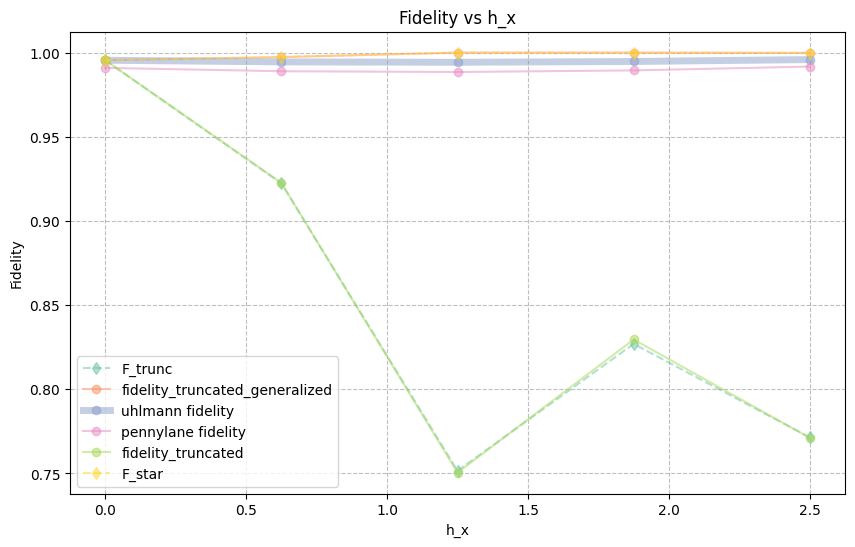

In [5]:
# plot fidelities
import seaborn as sns
sns.set_palette("Set2")
plt.figure(figsize=(10, 6))
plt.plot(df["h_x"], df["(Quantum) F_trunc"], label="F_trunc", marker='d', linestyle='--', alpha=0.5)
plt.plot(df["h_x"], df["(Classical) fidelity_truncated_generalized"], label="fidelity_truncated_generalized", marker='o', alpha=0.5)
plt.plot(df["h_x"], df["(Classical) uhlmann_fidelity"], label="uhlmann fidelity", marker='o', linewidth=5, alpha=0.5)
plt.plot(df["h_x"], df["(Classical) pennylane_fidelity"], label="pennylane fidelity", marker='o', alpha=0.5)
plt.plot(df["h_x"], df["(Classical) fidelity_truncated"], label="fidelity_truncated", marker='o', alpha=0.5)
plt.plot(df["h_x"], df["(Quantum) F_star"], label="F_star", marker='d', linestyle='--', alpha=0.5)
plt.xlabel("h_x")
plt.ylabel("Fidelity")
plt.title("Fidelity vs h_x")
plt.legend()
# use a discomtinuous line style grid
plt.grid(
    linestyle='--',
    color='gray',
    alpha=0.5
)
plt.show()

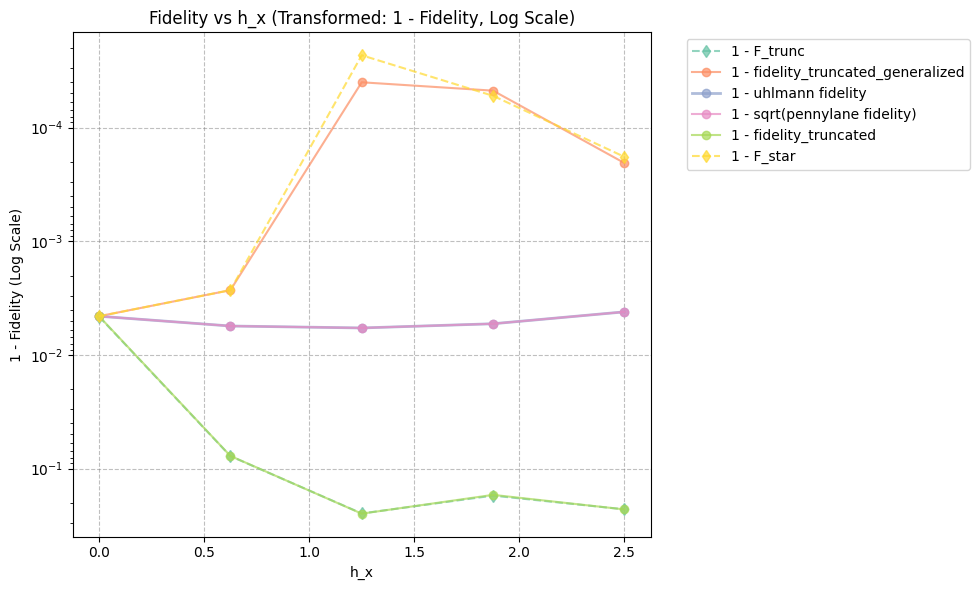

In [6]:
# logplot v2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Ensure no value is exactly 1, or 0 after 1-x transform for log scale
for col in df.columns:
    if "fidelity" in col or "F_" in col:
        df[col] = df[col].apply(lambda x: max(np.real(x), 1e-10)) # Ensure values are not exactly 0 for log plot later
        df[col] = df[col].apply(lambda x: min(np.real(x), 0.999999999)) # Ensure values are not exactly 1

sns.set_palette("Set2")
plt.figure(figsize=(10, 6))

# Plot 1 - fidelity for all series
plt.plot(df["h_x"], 1 - df["(Quantum) F_trunc"], label="1 - F_trunc", marker='d', linestyle='--', alpha=0.7)
plt.plot(df["h_x"], 1 - df["(Classical) fidelity_truncated_generalized"], label="1 - fidelity_truncated_generalized", marker='o', alpha=0.7)
plt.plot(df["h_x"], 1 - df["(Classical) uhlmann_fidelity"], label="1 - uhlmann fidelity", marker='o', linewidth=2, alpha=0.7) # Reduced linewidth
plt.plot(df["h_x"], 1 - np.sqrt(df["(Classical) pennylane_fidelity"]), label="1 - sqrt(pennylane fidelity)", marker='o', alpha=0.7)
plt.plot(df["h_x"], 1 - df["(Classical) fidelity_truncated"], label="1 - fidelity_truncated", marker='o', alpha=0.7)
plt.plot(df["h_x"], 1 - df["(Quantum) F_star"], label="1 - F_star", marker='d', linestyle='--', alpha=0.7)

plt.xlabel("h_x")
plt.ylabel("1 - Fidelity (Log Scale)")
plt.yscale("log") # Apply log scale to 1 - Fidelity

# Invert y-axis to show smaller "gap" values (closer to 0) at the bottom,
# which corresponds to fidelities closer to 1.
plt.gca().invert_yaxis()

# You might need to adjust y-limits based on your actual data range for 1 - fidelity
# For example, if your 1-fidelity values range from 1e-5 to 1e-1:
# plt.ylim(1e-1, 1e-5) # (max 1-fidelity, min 1-fidelity) after inversion

plt.title("Fidelity vs h_x (Transformed: 1 - Fidelity, Log Scale)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Adjust legend position
plt.grid(linestyle='--', color='gray', alpha=0.5)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

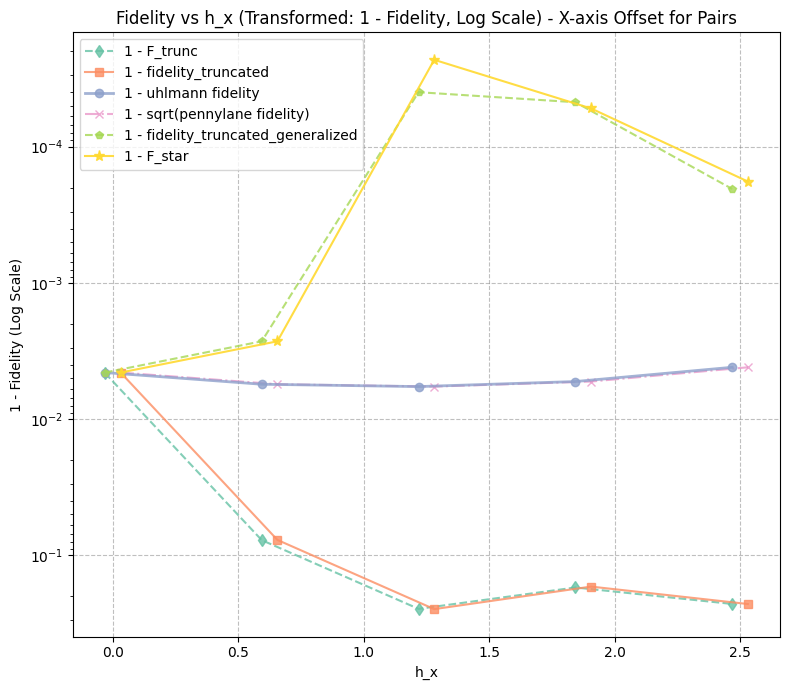

In [7]:
# diffplot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure no value is exactly 1, or 0 after 1-x transform for log scale
for col in df.columns:
    if "fidelity" in col or "F_" in col:
        df[col] = df[col].apply(lambda x: np.real(x))
        df[col] = df[col].apply(lambda x: max(x, 1e-10))
        df[col] = df[col].apply(lambda x: min(x, 0.999999999))


sns.set_palette("Set2")
plt.figure(figsize=(10, 7))

# Define a small x-offset value. Adjust this!
x_offset = (df["h_x"].iloc[1] - df["h_x"].iloc[0]) * 0.05
if x_offset == 0:
    x_offset = 0.01

# Define plotting properties for each line, removing 'color'
line_properties = {
    "(Quantum) F_trunc": {
        'label': "1 - F_trunc", 'marker': 'd', 'linestyle': '--',
        'alpha': 0.8, 'zorder': 3
    },
    "(Classical) fidelity_truncated": {
        'label': "1 - fidelity_truncated", 'marker': 's', 'linestyle': '-',
        'alpha': 0.8, 'zorder': 3
    },
    "(Classical) uhlmann_fidelity": {
        'label': "1 - uhlmann fidelity", 'marker': 'o', 'linestyle': '-',
        'linewidth': 2, 'alpha': 0.8, 'zorder': 3
    },
    "(Classical) pennylane_fidelity": {
        'label': "1 - pennylane fidelity", 'marker': '^', 'linestyle': ':',
        'alpha': 0.8, 'zorder': 3
    },
    "(Classical) fidelity_truncated_generalized": {
        'label': "1 - fidelity_truncated_generalized", 'marker': 'p', 'linestyle': '--',
        'alpha': 0.8, 'zorder': 4
    },
    "(Quantum) F_star": {
        'label': "1 - F_star", 'marker': '*', 'markersize': 8, 'linestyle': '-',
        'alpha': 0.9, 'zorder': 4
    },
    "1 - sqrt(pennylane_fidelity)": {
        'label': "1 - sqrt(pennylane fidelity)", 'marker': 'x', 'linestyle': '-.',
        'alpha': 0.7, 'zorder': 2
    }
}

# --- Plotting with X-axis Offsets ---

# Pair 1: F_trunc and fidelity_truncated
plt.plot(df["h_x"] - x_offset, 1 - df["(Quantum) F_trunc"], **line_properties["(Quantum) F_trunc"])
plt.plot(df["h_x"] + x_offset, 1 - df["(Classical) fidelity_truncated"], **line_properties["(Classical) fidelity_truncated"])


# Pair 2: uhlmann_fidelity and pennylane_fidelity (or its sqrt)
plt.plot(df["h_x"] - x_offset, 1 - df["(Classical) uhlmann_fidelity"], **line_properties["(Classical) uhlmann_fidelity"])
plt.plot(df["h_x"] + x_offset, 1 - np.sqrt(df["(Classical) pennylane_fidelity"]), **line_properties["1 - sqrt(pennylane_fidelity)"])


# Pair 3: fidelity_truncated_generalized and F_star
plt.plot(df["h_x"] - x_offset, 1 - df["(Classical) fidelity_truncated_generalized"], **line_properties["(Classical) fidelity_truncated_generalized"])
plt.plot(df["h_x"] + x_offset, 1 - df["(Quantum) F_star"], **line_properties["(Quantum) F_star"])


plt.xlabel("h_x")
plt.ylabel("1 - Fidelity (Log Scale)")
plt.yscale("log")

plt.gca().invert_yaxis()

plt.title("Fidelity vs h_x (Transformed: 1 - Fidelity, Log Scale) - X-axis Offset for Pairs")
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend()
plt.grid(linestyle='--', color='gray', alpha=0.5)
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()

In [8]:
uhlmann_fidelity = df["(Classical) uhlmann_fidelity"].values
uhlmann_fidelity

array([0.9954349 , 0.99443435, 0.99420925, 0.99468357, 0.99582163])

In [9]:
# compare states
## parameters
N=3
n=2
trace_out_indices = np.random.choice(range(N), size= N - n, replace=False)
time_t = 1.0
J=1
delta=0.5
delta_h_x=0.1

h_x=0.5
m=1
# initial_state=None
DEBUG=False
derivative_delta=1e-3
trotter_steps_K = 10
trotter_order = 2
print("N =",N, " starting number of qubits, before tracing out")
print("n =",n," final number of qubits")
print("trace_out_indices =",trace_out_indices)
print("J =",J)
#print("h_z =",h_z)
print("h_x =",h_x)
print("delta_h_x =",delta_h_x)
print("delta =",delta)
print("m =",m)
#print("DEBUG is set to: ",DEBUG)
print("trotter_steps_K =",trotter_steps_K)
print("trotter_order =",trotter_order)


# indices for quantum part
# trace out for the whole system composed by sys 1 and sys 2
active_rho = [x for x in list(range(N)) if x not in trace_out_indices] 
active_rho_delta = [x + N for x in active_rho]

measured_wires = active_rho + active_rho_delta
discarded_wires = [x for x in range(2*N) if x not in measured_wires]
h_z = 0.1


results = []


# classical fidelity
# classical

#model = density_generator.SpinChainXXZ(n=N, J=J, h_z=h_z, initial_state="0", DEBUG=DEBUG) 
model = density_generator.TransverseFieldIsingModel(n=N, J=J, h_x=h_x, initial_state="0", DEBUG=DEBUG)
print(f"Numerical H:\n{model.construct_hamiltonian()}") 

#rho_mixed, rho_delta_mixed = model.generate_mixed_density_matrices_with_perturbation(delta=delta,trace_out_indices=trace_out_indices)

rho_mixed, rho_delta_mixed = model.generate_mixed_states_with_perturbation(
    delta_h_x=delta_h_x,
    trace_out_indices=trace_out_indices,
    time=time_t,)

print(f"purity of rho_mixed: {np.trace(rho_mixed @ rho_mixed)}")
print(f"partcipation ratio of rho_mixed: {1/ np.trace(rho_mixed @ rho_mixed)}")

qobj_numeric_rho = helper_functions.dm_to_qobj(rho_mixed, title="rho_mixed")
qobj_numeric_rho_delta = helper_functions.dm_to_qobj(rho_delta_mixed, title="rho_delta_mixed")

classical_results = classicalQFI.compute_tqfi_bounds(rho_mixed, 
                                                     rho_delta_mixed, 
                                                     m, 
                                                     delta, 
                                                     DEBUG=False)

# quantum fidelity

#circuit_fn = circuit_generator.make_xx_plus_z_circuits(J, h_z, delta, N) 
# circuit_fn = circuit_generator.make_tfim_circuits(J, 
#                                                   h_x, 
#                                                   delta_h_x, 
#                                                   N, 
#                                                   time_evolution=time_t)

circuit_fn = circuit_generator.make_tfim_circuits_trotter_decomposition(J, 
                                                  h_x, 
                                                  delta_h_x, 
                                                  N, 
                                                  time_evolution=time_t,
                                                  trotter_steps=trotter_steps_K, 
                                                  order=trotter_order)

# IMPORTANT vogliuo rho o rho delta>?
STATE_RHO_OR_RHO_DELTA = "rho_delta" # rho or rho_delta

if STATE_RHO_OR_RHO_DELTA == "rho_delta": 
    print("measuring the density matrix, from the quantum system, for: rho_delta")
    q_dm = circuit_generator.get_density_matrix_circuit(circuit_factory=circuit_fn,
                                                    active_qubits=active_rho_delta)
elif STATE_RHO_OR_RHO_DELTA == "rho":
    print("measuring the density matrix, from the quantum system, for: rho")
    q_dm = circuit_generator.get_density_matrix_circuit(circuit_factory=circuit_fn,
                                                    active_qubits=active_rho)
else: 
    raise ValueError("STATE_RHO_OR_RHO_DELTA must be either 'rho' or 'rho_delta'")
# Load a device
dev = qml.device("default.qubit", wires=2 * N)

# Create the QNode for the density matrix circuit
density_matrix_qnode = qml.QNode(q_dm, dev)

# Execute the QNode to get the density matrix
quantum_density_matrix = density_matrix_qnode()
qobj_quantum_circuit = helper_functions.dm_to_qobj(quantum_density_matrix, title="quantum_density_matrix_rho_delta")

print(f"Density matrix of qubits {active_rho}:\n")


# Attach to a device and QNode
dev = qml.device("default.qubit", wires=2 * N)
vqfe_results = vqfe_subroutine.vqfe_from_circuit_disjoint(
    circuit_fn = circuit_fn,
    total_num_qubits=2*N,
    active_rho_wires = active_rho, 
    active_rho_delta_wires = active_rho_delta,
    L=2, 
    m=m, 
    maxiter= 256)

results.append({
    "hz": h_z,
    "(Classical) uhlmann_fidelity": classical_results["uhlmann_fidelity"],
    "(Classical) pennylane_fidelity": classical_results["fidelity_pennylane"],
    "(Classical) fidelity_truncated":classical_results["fidelity_truncated"],
    "(Classical) fidelity_truncated_generalized": classical_results["fidelity_truncated_generalized"],
    "(Quantum) F_trunc" : vqfe_results["F_trunc"].item(),
    "(Quantum) F_star" : vqfe_results["F_star"].item(),

})

# quantum fidelity
df = pd.DataFrame(results)


N = 3  starting number of qubits, before tracing out
n = 2  final number of qubits
trace_out_indices = [2]
J = 1
h_x = 0.5
delta_h_x = 0.1
delta = 0.5
m = 1
trotter_steps_K = 10
trotter_order = 2
Numerical H:
[[-2. +0.j -0.5+0.j -0.5+0.j  0. +0.j -0.5+0.j  0. +0.j  0. +0.j  0. +0.j]
 [-0.5+0.j  0. +0.j  0. +0.j -0.5+0.j  0. +0.j -0.5+0.j  0. +0.j  0. +0.j]
 [-0.5+0.j  0. +0.j  2. +0.j -0.5+0.j  0. +0.j  0. +0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j -0.5+0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j -0.5+0.j]
 [-0.5+0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j -0.5+0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  0. +0.j  0. +0.j -0.5+0.j  2. +0.j  0. +0.j -0.5+0.j]
 [ 0. +0.j  0. +0.j -0.5+0.j  0. +0.j -0.5+0.j  0. +0.j  0. +0.j -0.5+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -0.5+0.j  0. +0.j -0.5+0.j -0.5+0.j -2. +0.j]]
purity of rho_mixed: (0.9460606538170464+0j)
partcipation ratio of rho_mixed: (1.057014680787459+0j)
measuring the density matrix, from the quantum system, for: rho_delta
Density matrix of q

In [10]:
print(f"Numerical simulation")
print(qobj_numeric_rho)
print(f"pennylane circuit")
print(qobj_quantum_circuit)

Numerical simulation
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.79454834+0.j          0.12619315+0.03078939j  0.28584271-0.15599947j
   0.00476339-0.13252115j]
 [ 0.12619315-0.03078939j  0.04160929+0.j          0.03838894-0.03437827j
  -0.01217348-0.03143995j]
 [ 0.28584271+0.15599947j  0.03838894+0.03437827j  0.13361427+0.j
   0.02736261-0.0456924j ]
 [ 0.00476339+0.13252115j -0.01217348+0.03143995j  0.02736261+0.0456924j
   0.03022811+0.j        ]]
pennylane circuit
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.71693517+0.j          0.12547221+0.01491329j  0.31155503-0.15734662j
   0.001939  -0.16478566j]
 [ 0.12547221-0.01491329j  0.05443557+0.j          0.04876777-0.03042814j
  -0.01914659-0.04870186j]
 [ 0.31155503+0.15734662j  0.04876777+0.03042814j  0.17051671+0.j
   0.03603651-0.06786086j]
 [ 0.001939  +0.16478566j -0.01914659+0.04870186j  0.03603651+0.

In [11]:
qobj_numeric_rho


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.79454834+0.j          0.12619315+0.03078939j  0.28584271-0.15599947j
   0.00476339-0.13252115j]
 [ 0.12619315-0.03078939j  0.04160929+0.j          0.03838894-0.03437827j
  -0.01217348-0.03143995j]
 [ 0.28584271+0.15599947j  0.03838894+0.03437827j  0.13361427+0.j
   0.02736261-0.0456924j ]
 [ 0.00476339+0.13252115j -0.01217348+0.03143995j  0.02736261+0.0456924j
   0.03022811+0.j        ]]

In [12]:
qobj_quantum_circuit

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.71693517+0.j          0.12547221+0.01491329j  0.31155503-0.15734662j
   0.001939  -0.16478566j]
 [ 0.12547221-0.01491329j  0.05443557+0.j          0.04876777-0.03042814j
  -0.01914659-0.04870186j]
 [ 0.31155503+0.15734662j  0.04876777+0.03042814j  0.17051671+0.j
   0.03603651-0.06786086j]
 [ 0.001939  +0.16478566j -0.01914659+0.04870186j  0.03603651+0.06786086j
   0.05811255+0.j        ]]

In [13]:
qobj_numeric_rho_delta

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.71804789+0.j          0.12473686+0.01486987j  0.31135828-0.15692701j
   0.00308363-0.16501016j]
 [ 0.12473686-0.01486987j  0.05398468+0.j          0.04834687-0.03011878j
  -0.01879042-0.04850931j]
 [ 0.31135828+0.15692701j  0.04834687+0.03011878j  0.16990291+0.j
   0.03641938-0.06755342j]
 [ 0.00308363+0.16501016j -0.01879042+0.04850931j  0.03641938+0.06755342j
   0.05806452+0.j        ]]

In [14]:
import qutip # Assuming qutip is imported for dm_to_qobj and potentially fidelity calculation

# Calculate fidelity
# For two density matrices rho1 and rho2, the fidelity is F(rho1, rho2) = Tr(sqrt(sqrt(rho1) rho2 sqrt(rho1)))^2
# QuTiP has a built-in function for this.
print(f"IMPORTANT set comparison if rho or rho delta in the circuit")
fidelity = qutip.fidelity(qobj_quantum_circuit, qobj_numeric_rho_delta)
print("(CARE see if checking the same rho or rho_delta)")
print(f"\nFidelity between numerical and quantum_density_matrix from circuit : {fidelity}")

IMPORTANT set comparison if rho or rho delta in the circuit
(CARE see if checking the same rho or rho_delta)

Fidelity between numerical and quantum_density_matrix from circuit : 0.9999979286935209


(<Figure size 600x700 with 1 Axes>, <Axes: >)


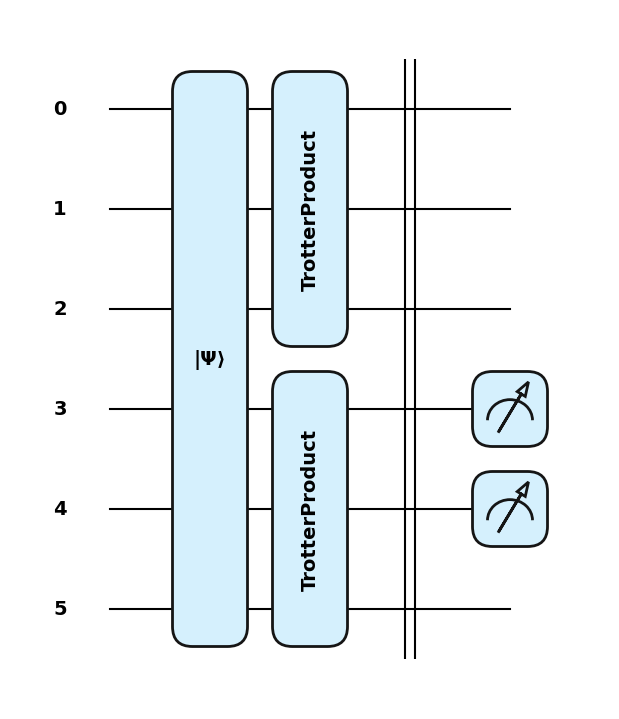

In [15]:
print(qml.draw_mpl(density_matrix_qnode, style="pennylane")())